In [1]:
%%time
%load_ext autoreload
from analysis_utils import *
from joblib import Parallel, delayed
import multiprocessing  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline

#Growth rate = 3.0
#Computes the translation latencies from our model with simulations containing
#1 to 14 cognate ternary complexes in the voxel (14 to 42 not included because
#the probability of voxels with that number of cognates is ~0)
path = "/Users/Akshay/Documents/tRNAShuffle/data/"
ensmbl_latency_dict = dict()
rxndiff=dict()
scalingFactor = 200
NR_scaledrates = {'k1r':718*200/scalingFactor,'k2f':1475*200/scalingFactor,'k2r_nr':1120*200/scalingFactor,'k3_nr':6*200/scalingFactor,'k4':209*200/scalingFactor}

data = "191003_2210/"
for i in range(1,7):
    sim_i = computeTransportRxnTimes(path+data,100*(i-1),100*(i-1)+100,cogtRNANum=i, ribosomeNum = 7,scaling=scalingFactor,NR_scaling = NR_scaledrates)
    ensmbl_latency_dict[i] = (CellLatencies(sim_i))

data = "191105_0908/"
for i in range(7,14):
    sim_i = computeTransportRxnTimes(path+data, 100*(i-1-6),100*(i-1-6)+100,cogtRNANum=i, ribosomeNum = 7,scaling=scalingFactor,NR_scaling = NR_scaledrates)
    ensmbl_latency_dict[i] = (CellLatencies(sim_i))
    
#Experimentally obtained codon usage frequencies and tRNA abundances at growth rate = 2.5 dbl/hr
gr25_Codon = np.array([2.36, 1.26, 45.55, 34.17, 16.97, 57.86, 19.27, 33.74, 14.98, 22.31, 43.18, 7.67, 24.11, 24.87, 39.49, 11.81, 0.03, 0.63, 2.19, 9.31, 17.22, 55.01, 5.61, 29.21, 21.67, 0.52, 15.79, 43.86, 4.17, 2.61, 20.64, 26.7, 7.03, 0.19, 2.76, 3.81, 6.72, 16.52, 4.27, 2.73, 7.92, 23.25, 2.51, 1.98, 16.33, 11.68, 0.62, 0.67, 43.82, 20.59, 27.28, 7.01, 6.78, 14.21, 60.75, 0.82, 3.86, 4.09, 28.82, 5.18, 4.38, 1.09])
gr25_pCodon = gr25_Codon/np.sum(gr25_Codon)
gr25_ptRNA = [0.0602409638554217, 0.010542168674698798, 0.07379518072289158, 0.00602409638554217, 0.010542168674698798, 0.00602409638554217, 0.021084337349397596, 0.043674698795180725, 0.021084337349397596, 0.01204819277108434, 0.01807228915662651, 0.08433734939759038, 0.03162650602409639, 0.07228915662650603, 0.01204819277108434, 0.07078313253012049, 0.06325301204819278, 0.01656626506024097, 0.009036144578313254, 0.027108433734939763, 0.010542168674698798, 0.03012048192771085, 0.013554216867469882, 0.015060240963855425, 0.0075301204819277125, 0.010542168674698798, 0.0075301204819277125, 0.003012048192771085, 0.021084337349397596, 0.004518072289156627, 0.01656626506024097, 0.01204819277108434, 0.0015060240963855425, 0.009036144578313254, 0.01656626506024097, 0.019578313253012052, 0.015060240963855425, 0.027108434, 0.05873493975903616, 0.019578313]
gr25_ptRNA = gr25_ptRNA/np.sum(gr25_ptRNA)

Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
CPU times: user 38.8 s, sys: 600 ms, total: 39.4 s
Wall time: 40.6 s


In [2]:
def compute_gene_elongt(codon_elongt):
    from Bio import SeqIO
    from Bio.Seq import Seq
    import pandas as pd
    from collections import Counter
    import numpy as np

    # Go through each gene in the genome and break it down into codons
    i = 0
    gene_map = {}
    codon_tags = ['GGG', 'GGA', 'GGU', 'GGC', 'GAG', 'GAA', 'GAU', 'GAC', 'GUG', 'GUA', 'GUU', 'GUC', 'GCG', 'GCA', 'GCU', 'GCC', 'AGG', 'AGA', 'AGU', 'AGC', 'AAG', 'AAA', 'AAU', 'AAC', 'AUG', 'AUA', 'AUU', 'AUC', 'ACG', 'ACA', 'ACU', 'ACC', 'UGG', 'UGA', 'UGU', 'UGC', 'UAU', 'UAC', 'UUG', 'UUA', 'UUU', 'UUC', 'UCG', 'UCA', 'UCU', 'UCC', 'CGG', 'CGA', 'CGU', 'CGC', 'CAG', 'CAA', 'CAU', 'CAC', 'CUG', 'CUA', 'CUU', 'CUC', 'CCG', 'CCA', 'CCU', 'CCC']
    for seq_record in SeqIO.parse("/Users/akshay/Documents/TranslationDynamics/data/All_genes_of_E._coli_K-12_substr._MG1655-2.fa", "fasta"):
        sequence = str(seq_record.seq).replace('T','U')
        sequence = [sequence[i:i+3] for i in range(0, len(sequence), 3)]
        gene_map[seq_record.id] = sequence
    print(len(gene_map))


    #Create dictionary of gene name and its description, so that we can delete any genes that encode RNA for direct use
    #(e.g., tRNA or rRNA) instead of mRNA
    gene_type = pd.read_csv('/Users/akshay/Documents/TranslationDynamics/data/Gene_Name_from_All_genes_of_E._coli_K-12_substr._MG1655-2.txt',sep='\t')
    gene_type_map = dict(zip(gene_type.AllGenes,gene_type.Geneproducts))

    del_count = 0
    for i,key in enumerate(gene_type_map.keys()):
        try:
            if('RNA' in gene_type_map[key]):
               del gene_map[key]
               del_count +=1
        except:
            nothing = 0
    print("Removed ", del_count, " RNA species")
    print(len(gene_map))

    #Go through each gene and, for each codon in that gene, add its elongation latency and then compute
    #the avg elongation latency for the gene. Remove hypothetical genes and other genes with nucleotide lenghts
    #that aren't divisible by 3 (typically a predicted or disproven gene)

    deleted = list()
    gene_latency = {}
    for gene in gene_map:
        elongt = 0
        gene_ok = True
        stops = 0
        for codon in gene_map[gene]:
            if codon != "UAA" and codon != "UAG":
                try:
                    elongt += codon_elongt[codon]
                except:
                    gene_ok = False
            else:
                stops +=1
        if gene_ok:
            elongt = elongt/(len(gene_map[gene])-stops)
            gene_latency[gene] = elongt
        else:
            deleted.append(gene)
    for gene in deleted:
        del gene_map[gene]

    print("Removed ", len(deleted), " non-divisible by three genes")
    print(len(gene_latency))
    return(gene_latency)

def get_gene_map():
    from Bio import SeqIO
    from Bio.Seq import Seq
    import pandas as pd
    from collections import Counter
    import numpy as np

    # Go through each gene in the genome and break it down into codons
    i = 0
    gene_map = {}
    codon_tags = ['GGG', 'GGA', 'GGU', 'GGC', 'GAG', 'GAA', 'GAU', 'GAC', 'GUG', 'GUA', 'GUU', 'GUC', 'GCG', 'GCA', 'GCU', 'GCC', 'AGG', 'AGA', 'AGU', 'AGC', 'AAG', 'AAA', 'AAU', 'AAC', 'AUG', 'AUA', 'AUU', 'AUC', 'ACG', 'ACA', 'ACU', 'ACC', 'UGG', 'UGA', 'UGU', 'UGC', 'UAU', 'UAC', 'UUG', 'UUA', 'UUU', 'UUC', 'UCG', 'UCA', 'UCU', 'UCC', 'CGG', 'CGA', 'CGU', 'CGC', 'CAG', 'CAA', 'CAU', 'CAC', 'CUG', 'CUA', 'CUU', 'CUC', 'CCG', 'CCA', 'CCU', 'CCC']
    for seq_record in SeqIO.parse("/Users/akshay/Documents/TranslationDynamics/data/All_genes_of_E._coli_K-12_substr._MG1655-2.fa", "fasta"):
        sequence = str(seq_record.seq).replace('T','U')
        sequence = [sequence[i:i+3] for i in range(0, len(sequence), 3)]
        gene_map[seq_record.id] = sequence
    return gene_map


4707
Removed  349  RNA species
4358
Removed  81  non-divisible by three genes
4277
195.65068863951427


Text(0, 0.5, 'Probability Density')

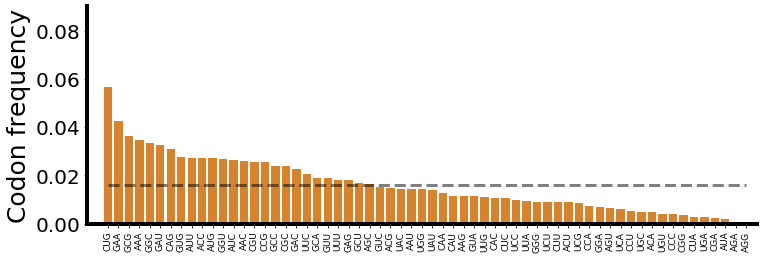

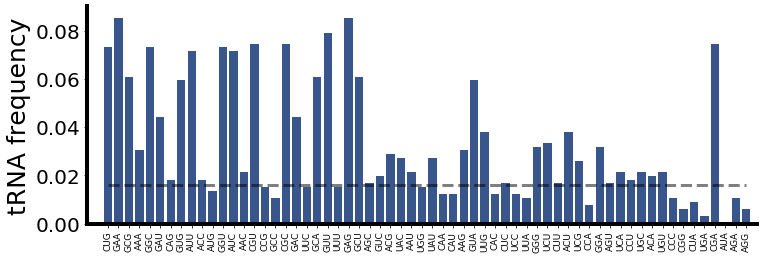

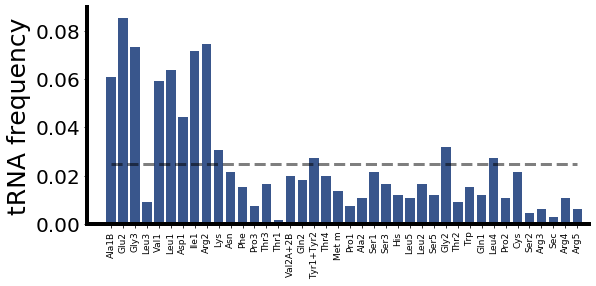

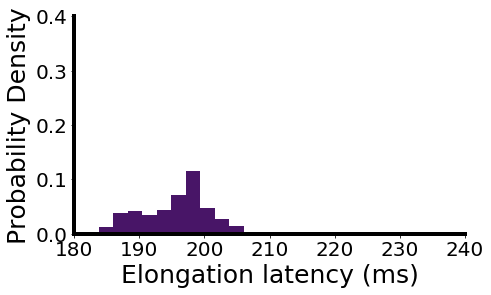

In [3]:
#Wildtype

tRNA_tags = ['Ala1B', 'Ala2', 'Arg2', 'Arg3', 'Arg4', 'Arg5', 'Asn', 'Asp1', 'Cys', 'Gln1', 'Gln2', 'Glu2', 'Gly2', 'Gly3', 'His', 'Ile1', 'Leu1', 'Leu2', 'Leu3', 'Leu4', 'Leu5', 'Lys', 'Met m', 'Phe', 'Pro1', 'Pro2', 'Pro3', 'Sec', 'Ser1', 'Ser2', 'Ser3', 'Ser5', 'Thr1', 'Thr2', 'Thr3', 'Thr4', 'Trp', 'Tyr1+Tyr2', 'Val1', 'Val2A+2B']
codon_tags = ['GGG', 'GGA', 'GGU', 'GGC', 'GAG', 'GAA', 'GAU', 'GAC', 'GUG', 'GUA', 'GUU', 'GUC', 'GCG', 'GCA', 'GCU', 'GCC', 'AGG', 'AGA', 'AGU', 'AGC', 'AAG', 'AAA', 'AAU', 'AAC', 'AUG', 'AUA', 'AUU', 'AUC', 'ACG', 'ACA', 'ACU', 'ACC', 'UGG', 'UGA', 'UGU', 'UGC', 'UAU', 'UAC', 'UUG', 'UUA', 'UUU', 'UUC', 'UCG', 'UCA', 'UCU', 'UCC', 'CGG', 'CGA', 'CGU', 'CGC', 'CAG', 'CAA', 'CAU', 'CAC', 'CUG', 'CUA', 'CUU', 'CUC', 'CCG', 'CCA', 'CCU', 'CCC']


##Compute the elongation latency of each gene weighted by transcript number
pCodon_zeros= np.zeros(len(gr25_pCodon))
codon_elongation_latency = list()
for i in range(len(pCodon_zeros)):
    pCodon_zeros= np.zeros(len(gr25_pCodon))
    pCodon_zeros[i] = 1
    codon_elongation_latency.append(computeElongationLatency(gr25_ptRNA,pCodon_zeros,ensmbl_latency_dict)[0][0])
codon_elongt = dict(zip(codon_tags, codon_elongation_latency))
gene_latency = compute_gene_elongt(codon_elongt)


transcriptome = pd.read_csv('./data/tables/srep45303-s9.csv')
transcriptome = transcriptome.head(4196)
transcriptome_dict = dict(zip(transcriptome['gene_name'],transcriptome['baseMean']))
transcriptome_codon_dict = dict(zip(codon_tags,np.zeros(62)))
transcriptome_elongt = list()
failed_counter = 0
gene_map = get_gene_map()
for gene in transcriptome_dict:
    try:
        for i in range(round(transcriptome_dict[gene])):
            transcriptome_elongt.append(gene_latency[gene])
            for codon in gene_map[gene]:
                transcriptome_codon_dict[codon] += 1
    except:
        failed_counter+=1
pCodon_transcriptome = [transcriptome_codon_dict[gene]/sum(transcriptome_codon_dict.values()) for gene in transcriptome_codon_dict]


ptRNA_dict, pcodon_dict, codon_dict, codonLabels, pCodon, tRNA_dict = cognateDistrib(gr25_ptRNA,pCodon_transcriptome,extra2=True)
codon_sorted_indices = np.flip(pCodon.argsort())
pCodon_sorted = pCodon[codon_sorted_indices]
codon_sorted = codonLabels[codon_sorted_indices]

fig,ax = plt.subplots(figsize=(12,4))
ax.bar(np.arange(62),pCodon_sorted,color='#d8832b',width=0.8)
ax.plot(np.arange(62),[1/62]*62,color='black',linewidth=3,linestyle='dashed',alpha=0.5)
plt.xticks(range(len(codon_tags)), codon_sorted,rotation='vertical')
ax.set_xlim(-2,62)
ax.set_ylabel('Codon frequency',fontsize=25)


## Sort tRNA distribution per codon
tRNA_sorted = [codon_dict[codon] for codon in codon_sorted]
ptRNA_sorted = [sum([ptRNA_dict[key] for key in tRNAs]) for tRNAs in tRNA_sorted]

fig,ax1 = plt.subplots(figsize=(12,4))
ax1.bar(np.arange(62),ptRNA_sorted,color='#39568CFF',width=0.8)
ax1.plot(np.arange(62),[1/62]*62,color='black',linewidth=3,linestyle='dashed',alpha=0.5)
plt.xticks(range(len(codon_tags)), codon_sorted,rotation='vertical')
ax1.set_xlim(-2,62)
ax1.set_ylabel('tRNA frequency',fontsize=25)


#### Sort tRNA distribution


###Sort Option 1
#tRNA_sorted = [codon_dict[codon] for codon in codon_sorted]
#tRNAs_sorted = [tRNA for tRNAs in tRNA_sorted for tRNA in tRNAs]
#tRNAs_sorted_reduced = []
#[tRNAs_sorted_reduced.append(tRNA) for tRNA in tRNAs_sorted if tRNA not in tRNAs_sorted_reduced]
#ptRNA_sorted = [ptRNA_dict[tRNA] for tRNA in tRNAs_sorted_reduced]
#fig,ax2 = plt.subplots(figsize=(9,4))
#ax2.bar(np.arange(40),ptRNA_sorted,color='#39568CFF',width=0.8)
#ax2.plot(np.arange(40),[1/40]*40,color='black',linewidth=3,linestyle='dashed',alpha=0.5)
#plt.xticks(range(len(tRNA_tags)), tRNAs_sorted_reduced,rotation='vertical')


###Sort option 2
#tRNA_sorted_indices = np.flip(gr25_ptRNA.argsort())
#ptRNA_sorted = gr25_ptRNA[tRNA_sorted_indices]
#tRNA_sorted = np.array(tRNA_tags)[tRNA_sorted_indices]
#fig,ax2 = plt.subplots(figsize=(9,4))
#ax2.bar(np.arange(40),ptRNA_sorted,color='#39568CFF',width=0.8)
#ax2.plot(np.arange(40),[1/40]*40,color='black',linewidth=3,linestyle='dashed',alpha=0.5)
#plt.xticks(range(len(tRNA_tags)), tRNA_sorted,rotation='vertical')

###Sort option 3
tRNA_sum_dict = tRNA_dict.copy()
tRNA_weightedbycodon = list()
#print(ptRNA_dict)
for keys in tRNA_dict.keys():
    tRNA_sum_dict[keys] = (sum([pcodon_dict[tRNA_key] for tRNA_key in tRNA_dict[keys]]))
#print(tRNA_sum_dict)
tRNA_weightedbycodon = list(tRNA_sum_dict.values())/sum(tRNA_sum_dict.values())
tRNA_sorted_indices = np.flip(tRNA_weightedbycodon.argsort())
tRNA_sorted = np.array(tRNA_tags)[tRNA_sorted_indices]
ptRNA_sorted = gr25_ptRNA[tRNA_sorted_indices]
fig,ax2 = plt.subplots(figsize=(9,4))
ax2.bar(np.arange(40),ptRNA_sorted,color='#39568CFF',width=0.8)
ax2.plot(np.arange(40),[1/40]*40,color='black',linewidth=3,linestyle='dashed',alpha=0.5)
plt.xticks(range(len(tRNA_tags)), tRNA_sorted,rotation='vertical')
#print(dict(zip(tRNA_sorted,ptRNA_sorted)))
ax2.set_xlim(-2,40)
ax2.set_ylabel('tRNA frequency',fontsize=25)


for ax in [ax,ax1,ax2]:
    ax.spines['left'].set_linewidth(4)
    ax.spines['bottom'].set_linewidth(4)
    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_linewidth(0)
    ax.tick_params(axis='y', which='major', labelsize=20)
    ax.tick_params(axis='x', which='major', labelsize=9)
    ax.set_ylim(0,0.09)
   # ax.set_yticks(np.arange(0,0.36,0.05))


#Plot the elongation latency of each gene
fig,ax = plt.subplots(figsize=(7,4))

hist=ax.hist(transcriptome_elongt,color='#481567FF',bins=20,density=True)
print(np.average(transcriptome_elongt))
ax.set_ylim(0,0.4)
ax.set_xlim(180,240)

ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=20)

ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.set_xlabel('Elongation latency (ms)',size=25)
ax.set_ylabel('Probability Density',size=25)

In [4]:
tRNA_sorted_indices = np.flip(gr25_ptRNA.argsort())
ptRNA_sorted = gr25_ptRNA[tRNA_sorted_indices]


In [5]:
tRNA_sorted = [codon_dict[codon] for codon in codon_sorted]
tRNAs_sorted = [tRNA for tRNAs in tRNA_sorted for tRNA in tRNAs]
tRNAs_sorted_reduced = []
[tRNAs_sorted_reduced.append(tRNA) for tRNA in tRNAs_sorted if tRNA not in tRNAs_sorted_reduced]
ptRNA_sorted = [ptRNA_dict[tRNA] for tRNA in tRNAs_sorted_reduced]
print(len(tRNAs_sorted_reduced))

40


4707
Removed  349  RNA species
4358
Removed  81  non-divisible by three genes
4277
214.18767629924233


Text(0, 0.5, 'Probability Density')

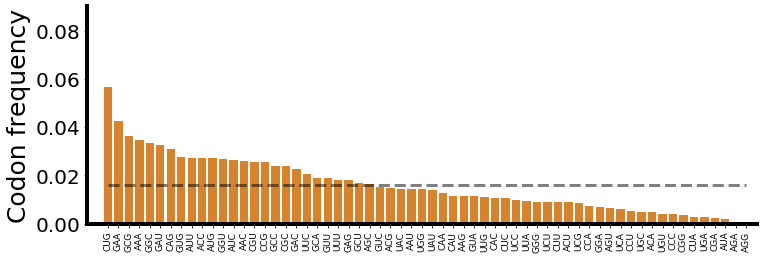

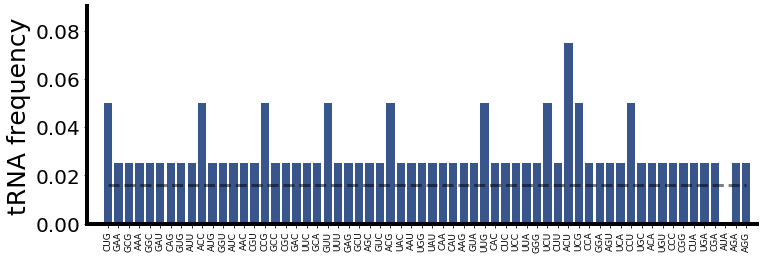

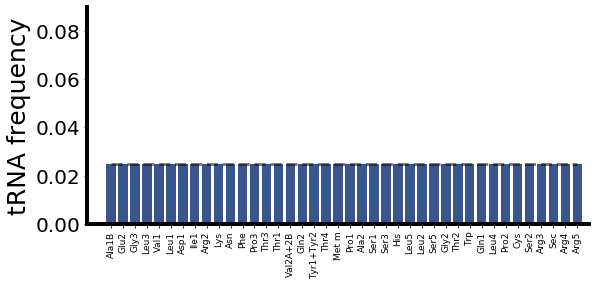

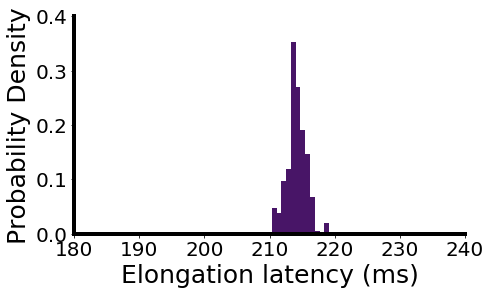

In [6]:
#Uniform
ptRNA_uniform = np.ones(len(gr25_ptRNA))/sum(np.ones(len(gr25_ptRNA)))
tRNA_tags = ['Ala1B', 'Ala2', 'Arg2', 'Arg3', 'Arg4', 'Arg5', 'Asn', 'Asp1', 'Cys', 'Gln1', 'Gln2', 'Glu2', 'Gly2', 'Gly3', 'His', 'Ile1', 'Leu1', 'Leu2', 'Leu3', 'Leu4', 'Leu5', 'Lys', 'Met m', 'Phe', 'Pro1', 'Pro2', 'Pro3', 'Sec', 'Ser1', 'Ser2', 'Ser3', 'Ser5', 'Thr1', 'Thr2', 'Thr3', 'Thr4', 'Trp', 'Tyr1+Tyr2', 'Val1', 'Val2A+2B']
codon_tags = ['GGG', 'GGA', 'GGU', 'GGC', 'GAG', 'GAA', 'GAU', 'GAC', 'GUG', 'GUA', 'GUU', 'GUC', 'GCG', 'GCA', 'GCU', 'GCC', 'AGG', 'AGA', 'AGU', 'AGC', 'AAG', 'AAA', 'AAU', 'AAC', 'AUG', 'AUA', 'AUU', 'AUC', 'ACG', 'ACA', 'ACU', 'ACC', 'UGG', 'UGA', 'UGU', 'UGC', 'UAU', 'UAC', 'UUG', 'UUA', 'UUU', 'UUC', 'UCG', 'UCA', 'UCU', 'UCC', 'CGG', 'CGA', 'CGU', 'CGC', 'CAG', 'CAA', 'CAU', 'CAC', 'CUG', 'CUA', 'CUU', 'CUC', 'CCG', 'CCA', 'CCU', 'CCC']


##Compute the elongation latency of each gene weighted by transcript number
pCodon_zeros= np.zeros(len(gr25_pCodon))
codon_elongation_latency = list()
for i in range(len(pCodon_zeros)):
    pCodon_zeros= np.zeros(len(gr25_pCodon))
    pCodon_zeros[i] = 1
    codon_elongation_latency.append(computeElongationLatency(ptRNA_uniform,pCodon_zeros,ensmbl_latency_dict)[0][0])
codon_elongt = dict(zip(codon_tags, codon_elongation_latency))
gene_latency = compute_gene_elongt(codon_elongt)


transcriptome = pd.read_csv('./data/tables/srep45303-s9.csv')
transcriptome = transcriptome.head(4196)
transcriptome_dict = dict(zip(transcriptome['gene_name'],transcriptome['baseMean']))
transcriptome_codon_dict = dict(zip(codon_tags,np.zeros(62)))
transcriptome_elongt = list()
failed_counter = 0
gene_map = get_gene_map()
for gene in transcriptome_dict:
    try:
        for i in range(round(transcriptome_dict[gene])):
            transcriptome_elongt.append(gene_latency[gene])
            for codon in gene_map[gene]:
                transcriptome_codon_dict[codon] += 1
    except:
        failed_counter+=1
pCodon_transcriptome = [transcriptome_codon_dict[gene]/sum(transcriptome_codon_dict.values()) for gene in transcriptome_codon_dict]


ptRNA_dict, pcodon_dict, codon_dict, codonLabels, pCodon, tRNA_dict = cognateDistrib(ptRNA_uniform,pCodon_transcriptome,extra2=True)
codon_sorted_indices = np.flip(pCodon.argsort())
pCodon_sorted = pCodon[codon_sorted_indices]
codon_sorted = codonLabels[codon_sorted_indices]

fig,ax = plt.subplots(figsize=(12,4))
ax.bar(np.arange(62),pCodon_sorted,color='#d8832b',width=0.8)
ax.plot(np.arange(62),[1/62]*62,color='black',linewidth=3,linestyle='dashed',alpha=0.5)
plt.xticks(range(len(codon_tags)), codon_sorted,rotation='vertical')
ax.set_xlim(-2,62)
ax.set_ylabel('Codon frequency',fontsize=25)


## Sort tRNA distribution per codon
tRNA_sorted = [codon_dict[codon] for codon in codon_sorted]
ptRNA_sorted = [sum([ptRNA_dict[key] for key in tRNAs]) for tRNAs in tRNA_sorted]

fig,ax1 = plt.subplots(figsize=(12,4))
ax1.bar(np.arange(62),ptRNA_sorted,color='#39568CFF',width=0.8)
ax1.plot(np.arange(62),[1/62]*62,color='black',linewidth=3,linestyle='dashed',alpha=0.5)
plt.xticks(range(len(codon_tags)), codon_sorted,rotation='vertical')
ax1.set_xlim(-2,62)
ax1.set_ylabel('tRNA frequency',fontsize=25)


#### Sort tRNA distribution


###Sort Option 1
#tRNA_sorted = [codon_dict[codon] for codon in codon_sorted]
#tRNAs_sorted = [tRNA for tRNAs in tRNA_sorted for tRNA in tRNAs]
#tRNAs_sorted_reduced = []
#[tRNAs_sorted_reduced.append(tRNA) for tRNA in tRNAs_sorted if tRNA not in tRNAs_sorted_reduced]
#ptRNA_sorted = [ptRNA_dict[tRNA] for tRNA in tRNAs_sorted_reduced]
#fig,ax2 = plt.subplots(figsize=(9,4))
#ax2.bar(np.arange(40),ptRNA_sorted,color='#39568CFF',width=0.8)
#ax2.plot(np.arange(40),[1/40]*40,color='black',linewidth=3,linestyle='dashed',alpha=0.5)
#plt.xticks(range(len(tRNA_tags)), tRNAs_sorted_reduced,rotation='vertical')


###Sort option 2
#tRNA_sorted_indices = np.flip(gr25_ptRNA.argsort())
#ptRNA_sorted = gr25_ptRNA[tRNA_sorted_indices]
#tRNA_sorted = np.array(tRNA_tags)[tRNA_sorted_indices]
#fig,ax2 = plt.subplots(figsize=(9,4))
#ax2.bar(np.arange(40),ptRNA_sorted,color='#39568CFF',width=0.8)
#ax2.plot(np.arange(40),[1/40]*40,color='black',linewidth=3,linestyle='dashed',alpha=0.5)
#plt.xticks(range(len(tRNA_tags)), tRNA_sorted,rotation='vertical')

###Sort option 3
tRNA_sum_dict = tRNA_dict.copy()
tRNA_weightedbycodon = list()
#print(ptRNA_dict)
for keys in tRNA_dict.keys():
    tRNA_sum_dict[keys] = (sum([pcodon_dict[tRNA_key] for tRNA_key in tRNA_dict[keys]]))
#print(tRNA_sum_dict)
tRNA_weightedbycodon = list(tRNA_sum_dict.values())/sum(tRNA_sum_dict.values())
tRNA_sorted_indices = np.flip(tRNA_weightedbycodon.argsort())
tRNA_sorted = np.array(tRNA_tags)[tRNA_sorted_indices]
ptRNA_sorted = ptRNA_uniform[tRNA_sorted_indices]
fig,ax2 = plt.subplots(figsize=(9,4))
ax2.bar(np.arange(40),ptRNA_sorted,color='#39568CFF',width=0.8)
ax2.plot(np.arange(40),[1/40]*40,color='black',linewidth=3,linestyle='dashed',alpha=0.5)
plt.xticks(range(len(tRNA_tags)), tRNA_sorted,rotation='vertical')
#print(dict(zip(tRNA_sorted,ptRNA_sorted)))
ax2.set_xlim(-2,40)
ax2.set_ylabel('tRNA frequency',fontsize=25)

for ax in [ax,ax1,ax2]:
    ax.spines['left'].set_linewidth(4)
    ax.spines['bottom'].set_linewidth(4)
    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_linewidth(0)
    ax.tick_params(axis='y', which='major', labelsize=20)
    ax.tick_params(axis='x', which='major', labelsize=9)
    ax.set_ylim(0,0.09)
   # ax.set_yticks(np.arange(0,0.36,0.05))


#Plot the elongation latency of each gene
fig,ax = plt.subplots(figsize=(7,4))

hist=ax.hist(transcriptome_elongt,color='#481567FF',bins=20,density=True)
print(np.average(transcriptome_elongt))
ax.set_ylim(0,0.4)
ax.set_xlim(180,240)

ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=20)

ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.set_xlabel('Elongation latency (ms)',size=25)
ax.set_ylabel('Probability Density',size=25)

4707
Removed  349  RNA species
4358
Removed  81  non-divisible by three genes
4277
230.1505368280038


Text(0, 0.5, 'Probability Density')

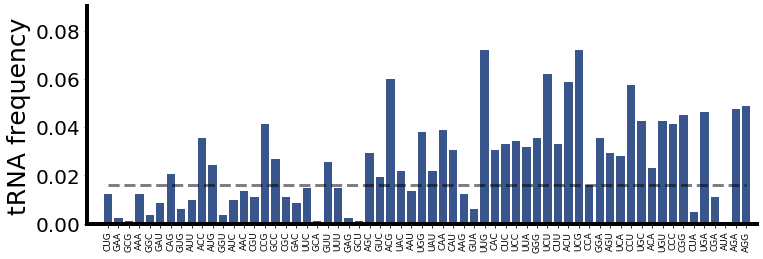

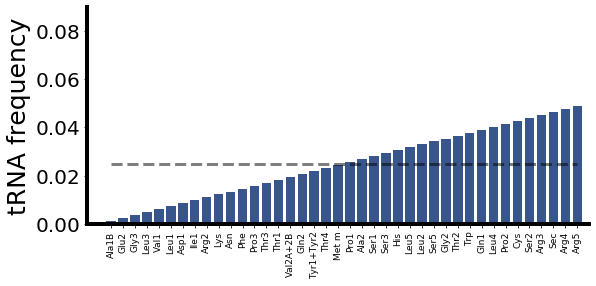

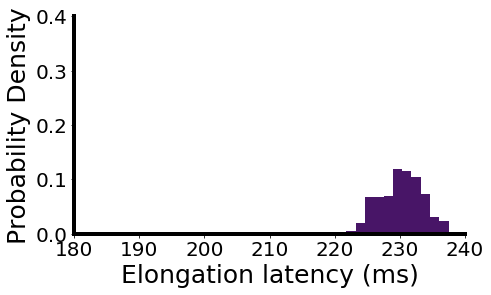

In [8]:
#monotonic increase
tRNA_tags = ['Ala1B', 'Ala2', 'Arg2', 'Arg3', 'Arg4', 'Arg5', 'Asn', 'Asp1', 'Cys', 'Gln1', 'Gln2', 'Glu2', 'Gly2', 'Gly3', 'His', 'Ile1', 'Leu1', 'Leu2', 'Leu3', 'Leu4', 'Leu5', 'Lys', 'Met m', 'Phe', 'Pro1', 'Pro2', 'Pro3', 'Sec', 'Ser1', 'Ser2', 'Ser3', 'Ser5', 'Thr1', 'Thr2', 'Thr3', 'Thr4', 'Trp', 'Tyr1+Tyr2', 'Val1', 'Val2A+2B']
codon_tags = ['GGG', 'GGA', 'GGU', 'GGC', 'GAG', 'GAA', 'GAU', 'GAC', 'GUG', 'GUA', 'GUU', 'GUC', 'GCG', 'GCA', 'GCU', 'GCC', 'AGG', 'AGA', 'AGU', 'AGC', 'AAG', 'AAA', 'AAU', 'AAC', 'AUG', 'AUA', 'AUU', 'AUC', 'ACG', 'ACA', 'ACU', 'ACC', 'UGG', 'UGA', 'UGU', 'UGC', 'UAU', 'UAC', 'UUG', 'UUA', 'UUU', 'UUC', 'UCG', 'UCA', 'UCU', 'UCC', 'CGG', 'CGA', 'CGU', 'CGC', 'CAG', 'CAA', 'CAU', 'CAC', 'CUG', 'CUA', 'CUU', 'CUC', 'CCG', 'CCA', 'CCU', 'CCC']

ptRNA_sorted = (0.12195+np.arange(0,40)*0.12195)/sum(0.12195+np.arange(0,40)*0.12195)
sortedtRNAdict = dict(zip(tRNA_sorted, ptRNA_sorted))
resortedtRNA = [sortedtRNAdict[tRNA] for tRNA in tRNA_tags]


##Compute the elongation latency of each gene weighted by transcript number
pCodon_zeros= np.zeros(len(gr25_pCodon))
codon_elongation_latency = list()
for i in range(len(pCodon_zeros)):
    pCodon_zeros= np.zeros(len(gr25_pCodon))
    pCodon_zeros[i] = 1
    codon_elongation_latency.append(computeElongationLatency(resortedtRNA,pCodon_zeros,ensmbl_latency_dict)[0][0])
codon_elongt = dict(zip(codon_tags, codon_elongation_latency))
gene_latency = compute_gene_elongt(codon_elongt)


transcriptome = pd.read_csv('./data/tables/srep45303-s9.csv')
transcriptome = transcriptome.head(4196)
transcriptome_dict = dict(zip(transcriptome['gene_name'],transcriptome['baseMean']))
transcriptome_codon_dict = dict(zip(codon_tags,np.zeros(62)))
transcriptome_elongt = list()
failed_counter = 0
gene_map = get_gene_map()
for gene in transcriptome_dict:
    try:
        for i in range(round(transcriptome_dict[gene])):
            transcriptome_elongt.append(gene_latency[gene])
            for codon in gene_map[gene]:
                transcriptome_codon_dict[codon] += 1
    except:
        failed_counter+=1
pCodon_transcriptome = [transcriptome_codon_dict[gene]/sum(transcriptome_codon_dict.values()) for gene in transcriptome_codon_dict]


ptRNA_dict, pcodon_dict, codon_dict, codonLabels, pCodon, tRNA_dict = cognateDistrib(resortedtRNA,pCodon_transcriptome,extra2=True)
codon_sorted_indices = np.flip(pCodon.argsort())
pCodon_sorted = pCodon[codon_sorted_indices]
codon_sorted = codonLabels[codon_sorted_indices]

## Sort tRNA distribution per codon
tRNA_sorted1 = [codon_dict[codon] for codon in codon_sorted]
ptRNA_sorted1 = [sum([ptRNA_dict[key] for key in tRNAs]) for tRNAs in tRNA_sorted1]

fig,ax1 = plt.subplots(figsize=(12,4))
ax1.bar(np.arange(62),ptRNA_sorted1,color='#39568CFF',width=0.8)
ax1.plot(np.arange(62),[1/62]*62,color='black',linewidth=3,linestyle='dashed',alpha=0.5)
plt.xticks(range(len(codon_tags)), codon_sorted,rotation='vertical')
ax1.set_xlim(-2,62)
ax1.set_ylabel('tRNA frequency',fontsize=25)



#### Sort tRNA distribution


###Sort Option 1
#tRNA_sorted = [codon_dict[codon] for codon in codon_sorted]
#tRNAs_sorted = [tRNA for tRNAs in tRNA_sorted for tRNA in tRNAs]
#tRNAs_sorted_reduced = []
#[tRNAs_sorted_reduced.append(tRNA) for tRNA in tRNAs_sorted if tRNA not in tRNAs_sorted_reduced]
#ptRNA_sorted = [ptRNA_dict[tRNA] for tRNA in tRNAs_sorted_reduced]
#fig,ax2 = plt.subplots(figsize=(9,4))
#ax2.bar(np.arange(40),ptRNA_sorted,color='#39568CFF',width=0.8)
#ax2.plot(np.arange(40),[1/40]*40,color='black',linewidth=3,linestyle='dashed',alpha=0.5)
#plt.xticks(range(len(tRNA_tags)), tRNAs_sorted_reduced,rotation='vertical')


###Sort option 2
#tRNA_sorted_indices = np.flip(gr25_ptRNA.argsort())
#ptRNA_sorted = gr25_ptRNA[tRNA_sorted_indices]
#tRNA_sorted = np.array(tRNA_tags)[tRNA_sorted_indices]
#fig,ax2 = plt.subplots(figsize=(9,4))
#ax2.bar(np.arange(40),ptRNA_sorted,color='#39568CFF',width=0.8)
#ax2.plot(np.arange(40),[1/40]*40,color='black',linewidth=3,linestyle='dashed',alpha=0.5)
#plt.xticks(range(len(tRNA_tags)), tRNA_sorted,rotation='vertical')

###Sort option 3
tRNA_sum_dict = tRNA_dict.copy()
tRNA_weightedbycodon = list()
#print(ptRNA_dict)
for keys in tRNA_dict.keys():
    tRNA_sum_dict[keys] = (sum([pcodon_dict[tRNA_key] for tRNA_key in tRNA_dict[keys]]))
#print(tRNA_sum_dict)
tRNA_weightedbycodon = list(tRNA_sum_dict.values())/sum(tRNA_sum_dict.values())
tRNA_sorted_indices = np.flip(tRNA_weightedbycodon.argsort())
tRNA_sorted = np.array(tRNA_tags)[tRNA_sorted_indices]
fig,ax2 = plt.subplots(figsize=(9,4))
ax2.bar(np.arange(40),ptRNA_sorted,color='#39568CFF',width=0.8)
ax2.plot(np.arange(40),[1/40]*40,color='black',linewidth=3,linestyle='dashed',alpha=0.5)
plt.xticks(range(len(tRNA_tags)), tRNA_sorted,rotation='vertical')
#print(dict(zip(tRNA_sorted,ptRNA_sorted)))
ax2.set_xlim(-2,40)
ax2.set_ylabel('tRNA frequency',fontsize=25)


for ax in [ax,ax1,ax2]:
    ax.spines['left'].set_linewidth(4)
    ax.spines['bottom'].set_linewidth(4)
    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_linewidth(0)
    ax.tick_params(axis='y', which='major', labelsize=20)
    ax.tick_params(axis='x', which='major', labelsize=9)
    ax.set_ylim(0,0.09)
   # ax.set_yticks(np.arange(0,0.36,0.05))


#Plot the elongation latency of each gene
fig,ax = plt.subplots(figsize=(7,4))

hist=ax.hist(transcriptome_elongt,color='#481567FF',bins=20,density=True)
print(np.average(transcriptome_elongt))
ax.set_ylim(0,0.4)
ax.set_xlim(180,240)

ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=20)

ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.set_xlabel('Elongation latency (ms)',size=25)
ax.set_ylabel('Probability Density',size=25)

4707
Removed  349  RNA species
4358
Removed  81  non-divisible by three genes
4277
194.59679851968247


Text(0, 0.5, 'Probability Density')

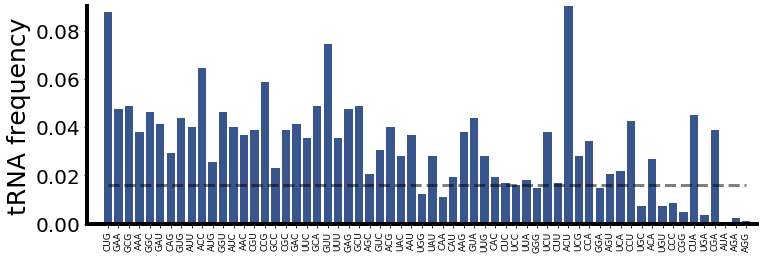

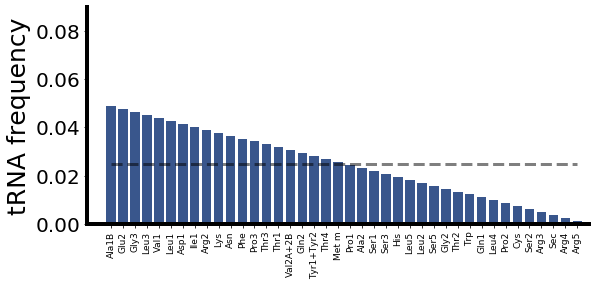

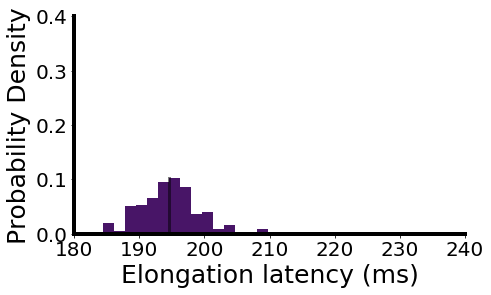

In [12]:
#monotonic decrease
tRNA_tags = ['Ala1B', 'Ala2', 'Arg2', 'Arg3', 'Arg4', 'Arg5', 'Asn', 'Asp1', 'Cys', 'Gln1', 'Gln2', 'Glu2', 'Gly2', 'Gly3', 'His', 'Ile1', 'Leu1', 'Leu2', 'Leu3', 'Leu4', 'Leu5', 'Lys', 'Met m', 'Phe', 'Pro1', 'Pro2', 'Pro3', 'Sec', 'Ser1', 'Ser2', 'Ser3', 'Ser5', 'Thr1', 'Thr2', 'Thr3', 'Thr4', 'Trp', 'Tyr1+Tyr2', 'Val1', 'Val2A+2B']
codon_tags = ['GGG', 'GGA', 'GGU', 'GGC', 'GAG', 'GAA', 'GAU', 'GAC', 'GUG', 'GUA', 'GUU', 'GUC', 'GCG', 'GCA', 'GCU', 'GCC', 'AGG', 'AGA', 'AGU', 'AGC', 'AAG', 'AAA', 'AAU', 'AAC', 'AUG', 'AUA', 'AUU', 'AUC', 'ACG', 'ACA', 'ACU', 'ACC', 'UGG', 'UGA', 'UGU', 'UGC', 'UAU', 'UAC', 'UUG', 'UUA', 'UUU', 'UUC', 'UCG', 'UCA', 'UCU', 'UCC', 'CGG', 'CGA', 'CGU', 'CGC', 'CAG', 'CAA', 'CAU', 'CAC', 'CUG', 'CUA', 'CUU', 'CUC', 'CCG', 'CCA', 'CCU', 'CCC']

ptRNA_sorted = np.flip((0.12195+np.arange(0,40)*0.12195)/sum(0.12195+np.arange(0,40)*0.12195))
sortedtRNAdict = dict(zip(tRNA_sorted, ptRNA_sorted))
resortedtRNA = [sortedtRNAdict[tRNA] for tRNA in tRNA_tags]


##Compute the elongation latency of each gene weighted by transcript number
pCodon_zeros= np.zeros(len(gr25_pCodon))
codon_elongation_latency = list()
for i in range(len(pCodon_zeros)):
    pCodon_zeros= np.zeros(len(gr25_pCodon))
    pCodon_zeros[i] = 1
    codon_elongation_latency.append(computeElongationLatency(resortedtRNA,pCodon_zeros,ensmbl_latency_dict)[0][0])
codon_elongt = dict(zip(codon_tags, codon_elongation_latency))
gene_latency = compute_gene_elongt(codon_elongt)


transcriptome = pd.read_csv('./data/tables/srep45303-s9.csv')
transcriptome = transcriptome.head(4196)
transcriptome_dict = dict(zip(transcriptome['gene_name'],transcriptome['baseMean']))
transcriptome_codon_dict = dict(zip(codon_tags,np.zeros(62)))
transcriptome_elongt = list()
failed_counter = 0
gene_map = get_gene_map()
for gene in transcriptome_dict:
    try:
        for i in range(round(transcriptome_dict[gene])):
            transcriptome_elongt.append(gene_latency[gene])
            for codon in gene_map[gene]:
                transcriptome_codon_dict[codon] += 1
    except:
        failed_counter+=1
pCodon_transcriptome = [transcriptome_codon_dict[gene]/sum(transcriptome_codon_dict.values()) for gene in transcriptome_codon_dict]


ptRNA_dict, pcodon_dict, codon_dict, codonLabels, pCodon, tRNA_dict = cognateDistrib(resortedtRNA,pCodon_transcriptome,extra2=True)
codon_sorted_indices = np.flip(pCodon.argsort())
pCodon_sorted = pCodon[codon_sorted_indices]
codon_sorted = codonLabels[codon_sorted_indices]

## Sort tRNA distribution per codon
tRNA_sorted1 = [codon_dict[codon] for codon in codon_sorted]
ptRNA_sorted1 = [sum([ptRNA_dict[key] for key in tRNAs]) for tRNAs in tRNA_sorted1]

fig,ax1 = plt.subplots(figsize=(12,4))
ax1.bar(np.arange(62),ptRNA_sorted1,color='#39568CFF',width=0.8)
ax1.plot(np.arange(62),[1/62]*62,color='black',linewidth=3,linestyle='dashed',alpha=0.5)
plt.xticks(range(len(codon_tags)), codon_sorted,rotation='vertical')
ax1.set_xlim(-2,62)
ax1.set_ylabel('tRNA frequency',fontsize=25)



#### Sort tRNA distribution


###Sort Option 1
#tRNA_sorted = [codon_dict[codon] for codon in codon_sorted]
#tRNAs_sorted = [tRNA for tRNAs in tRNA_sorted for tRNA in tRNAs]
#tRNAs_sorted_reduced = []
#[tRNAs_sorted_reduced.append(tRNA) for tRNA in tRNAs_sorted if tRNA not in tRNAs_sorted_reduced]
#ptRNA_sorted = [ptRNA_dict[tRNA] for tRNA in tRNAs_sorted_reduced]
#fig,ax2 = plt.subplots(figsize=(9,4))
#ax2.bar(np.arange(40),ptRNA_sorted,color='#39568CFF',width=0.8)
#ax2.plot(np.arange(40),[1/40]*40,color='black',linewidth=3,linestyle='dashed',alpha=0.5)
#plt.xticks(range(len(tRNA_tags)), tRNAs_sorted_reduced,rotation='vertical')


###Sort option 2
#tRNA_sorted_indices = np.flip(gr25_ptRNA.argsort())
#ptRNA_sorted = gr25_ptRNA[tRNA_sorted_indices]
#tRNA_sorted = np.array(tRNA_tags)[tRNA_sorted_indices]
#fig,ax2 = plt.subplots(figsize=(9,4))
#ax2.bar(np.arange(40),ptRNA_sorted,color='#39568CFF',width=0.8)
#ax2.plot(np.arange(40),[1/40]*40,color='black',linewidth=3,linestyle='dashed',alpha=0.5)
#plt.xticks(range(len(tRNA_tags)), tRNA_sorted,rotation='vertical')

###Sort option 3
tRNA_sum_dict = tRNA_dict.copy()
tRNA_weightedbycodon = list()
#print(ptRNA_dict)
for keys in tRNA_dict.keys():
    tRNA_sum_dict[keys] = (sum([pcodon_dict[tRNA_key] for tRNA_key in tRNA_dict[keys]]))
#print(tRNA_sum_dict)
tRNA_weightedbycodon = list(tRNA_sum_dict.values())/sum(tRNA_sum_dict.values())
tRNA_sorted_indices = np.flip(tRNA_weightedbycodon.argsort())
tRNA_sorted = np.array(tRNA_tags)[tRNA_sorted_indices]
fig,ax2 = plt.subplots(figsize=(9,4))
ax2.bar(np.arange(40),ptRNA_sorted,color='#39568CFF',width=0.8)
ax2.plot(np.arange(40),[1/40]*40,color='black',linewidth=3,linestyle='dashed',alpha=0.5)
plt.xticks(range(len(tRNA_tags)), tRNA_sorted,rotation='vertical')
#print(dict(zip(tRNA_sorted,ptRNA_sorted)))
ax2.set_xlim(-2,40)
ax2.set_ylabel('tRNA frequency',fontsize=25)


for ax in [ax,ax1,ax2]:
    ax.spines['left'].set_linewidth(4)
    ax.spines['bottom'].set_linewidth(4)
    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_linewidth(0)
    ax.tick_params(axis='y', which='major', labelsize=20)
    ax.tick_params(axis='x', which='major', labelsize=9)
    ax.set_ylim(0,0.09)
   # ax.set_yticks(np.arange(0,0.36,0.05))


#Plot the elongation latency of each gene
fig,ax = plt.subplots(figsize=(7,4))

hist=ax.hist(transcriptome_elongt,color='#481567FF',bins=20,density=True)
print(np.average(transcriptome_elongt))
ax.plot([np.average(transcriptome_elongt)]*100,np.linspace(0,max(hist[0]),100),linewidth=3,color='black',alpha=0.5)

ax.set_ylim(0,0.4)
ax.set_xlim(180,240)

ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=20)

ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.set_xlabel('Elongation latency (ms)',size=25)
ax.set_ylabel('Probability Density',size=25)